# Does the size of convolution kernels affect classifier performance? (Assuming parameter count is the same)

In [1]:
from __future__ import print_function
import keras

Using TensorFlow backend.


In [2]:
import os
import numpy as np
import Bio
from Bio import SeqIO
import seaborn as sns
import pandas as pd
import Bio.motifs
%matplotlib inline
from sklearn import model_selection
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import scipy
sns.set_context('notebook')

In [3]:
# if not os.path.isdir('/home/jtao/analysis/genomic_grammar_analysis/'):
#     os.mkdir('/home/jtao/analysis/genomic_grammar_analysis')
# os.chdir('/home/jtao/analysis/genomic_grammar_analysis')
working_directory = '/home/jtao/analysis/genomic_grammar_analysis'

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from signal_models import *

In [6]:
from utility_functions import *

## Try different k-mer sizes

In [15]:
all_rocs = []
all_accuracies = []
all_precisions = []
k_list = []
all_treatments = []
for ps in ['c57bl6_kla-1h_peaks.fasta', 'c57bl6_veh_peaks.fasta', 'c57bl6_il4-24h_peaks.fasta']:
    print(ps)
    positive_seqRecords = list(SeqIO.parse(working_directory + '/peak_sequences/' + ps, 'fasta'))
    negative_seqRecords = list(SeqIO.parse(working_directory + '/background_files/' + ps.replace('_peaks', '_background'), 'fasta'))[:len(positive_seqRecords)]

    fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords] + [str(x[:200].seq) for x in negative_seqRecords]

    fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords] + \
        [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]

    sequence_arrays = convert_sequences_to_array(fasta_seq)

    sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)


    labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
    labels = np.array(labels)

    x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)

    num_classes = 2
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    for k in range(2,24,2):
        max_kmers = 4**k
        param_count=0
        kmers_to_use = 0
        while param_count <= 1552 - (4*k+1):
            kmers_to_use +=1
            param_count += (4*k+1)
        kmers_to_use = min(kmers_to_use, max_kmers)

        current_model = get_convolution_model(
            200,
            'classification',
            num_classes = 2,
            num_motifs = kmers_to_use,
            motif_size = k,
            num_dense_neurons = 32, 
            dropout_rate = 0.5)

        current_model.fit([x_train, x_rc_train], y_train,
              batch_size=64,
              epochs=10,
              verbose=1,
              validation_data=([x_test, x_rc_test], y_test))

        probs = current_model.predict([x_test, x_rc_test])
        test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
        roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
        precision = sklearn.metrics.precision_score([y[1] for y in y_test], test_predictions)
        acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
        treatment = ps.split('_')[1]
        
        print(treatment, k, max_kmers, kmers_to_use, param_count)
        print(roc, precision, acc)

        all_rocs.append(roc)
        all_accuracies.append(acc)
        all_precisions.append(precision)
        k_list.append(k)
        all_treatments.append(treatment)

c57bl6_kla-1h_peaks.fasta
Train on 34841 samples, validate on 8711 samples
Epoch 1/10
34841/34841 [==============================] - 10s 276us/step - loss: 0.6945 - categorical_accuracy: 0.5042 - val_loss: 0.6931 - val_categorical_accuracy: 0.4989
Epoch 2/10
34841/34841 [==============================] - 5s 144us/step - loss: 0.6931 - categorical_accuracy: 0.5047 - val_loss: 0.6930 - val_categorical_accuracy: 0.5056
Epoch 3/10
34841/34841 [==============================] - 5s 140us/step - loss: 0.6928 - categorical_accuracy: 0.5109 - val_loss: 0.6921 - val_categorical_accuracy: 0.5413
Epoch 4/10
34841/34841 [==============================] - 4s 126us/step - loss: 0.6919 - categorical_accuracy: 0.5188 - val_loss: 0.6901 - val_categorical_accuracy: 0.5413
Epoch 5/10
34841/34841 [==============================] - 5s 143us/step - loss: 0.6908 - categorical_accuracy: 0.5207 - val_loss: 0.6885 - val_categorical_accuracy: 0.5413
Epoch 6/10
34841/34841 [==============================] - 6s 172

34841/34841 [==============================] - 6s 167us/step - loss: 0.4514 - categorical_accuracy: 0.7921 - val_loss: 0.4176 - val_categorical_accuracy: 0.8096
Epoch 6/10
34841/34841 [==============================] - 6s 166us/step - loss: 0.4391 - categorical_accuracy: 0.8008 - val_loss: 0.4177 - val_categorical_accuracy: 0.8102
Epoch 7/10
34841/34841 [==============================] - 6s 166us/step - loss: 0.4370 - categorical_accuracy: 0.8008 - val_loss: 0.4199 - val_categorical_accuracy: 0.8091
Epoch 8/10
34841/34841 [==============================] - 6s 166us/step - loss: 0.4267 - categorical_accuracy: 0.8082 - val_loss: 0.4149 - val_categorical_accuracy: 0.8158
Epoch 9/10
34841/34841 [==============================] - 6s 164us/step - loss: 0.4304 - categorical_accuracy: 0.8059 - val_loss: 0.4101 - val_categorical_accuracy: 0.8122
Epoch 10/10
34841/34841 [==============================] - 6s 181us/step - loss: 0.4213 - categorical_accuracy: 0.8140 - val_loss: 0.4160 - val_categor

34841/34841 [==============================] - 6s 185us/step - loss: 0.4105 - categorical_accuracy: 0.8196 - val_loss: 0.4167 - val_categorical_accuracy: 0.8130
Epoch 10/10
34841/34841 [==============================] - 6s 184us/step - loss: 0.4048 - categorical_accuracy: 0.8239 - val_loss: 0.4108 - val_categorical_accuracy: 0.8115
kla-1h 18 68719476736 21 1533
0.8961860888789787 0.7702997816160413 0.8115026977384916
Train on 34841 samples, validate on 8711 samples
Epoch 1/10
34841/34841 [==============================] - 13s 378us/step - loss: 0.6751 - categorical_accuracy: 0.5683 - val_loss: 0.6108 - val_categorical_accuracy: 0.6905
Epoch 2/10
34841/34841 [==============================] - 7s 192us/step - loss: 0.5605 - categorical_accuracy: 0.7184 - val_loss: 0.4848 - val_categorical_accuracy: 0.7693
Epoch 3/10
34841/34841 [==============================] - 7s 194us/step - loss: 0.4902 - categorical_accuracy: 0.7708 - val_loss: 0.4438 - val_categorical_accuracy: 0.7908
Epoch 4/10
34

50480/50480 [==============================] - 9s 180us/step - loss: 0.5381 - categorical_accuracy: 0.7408 - val_loss: 0.4809 - val_categorical_accuracy: 0.7698
Epoch 3/10
50480/50480 [==============================] - 9s 181us/step - loss: 0.5001 - categorical_accuracy: 0.7675 - val_loss: 0.4906 - val_categorical_accuracy: 0.7650
Epoch 4/10
50480/50480 [==============================] - 9s 183us/step - loss: 0.4877 - categorical_accuracy: 0.7757 - val_loss: 0.4529 - val_categorical_accuracy: 0.7887
Epoch 5/10
50480/50480 [==============================] - 9s 181us/step - loss: 0.4767 - categorical_accuracy: 0.7797 - val_loss: 0.4488 - val_categorical_accuracy: 0.7881
Epoch 6/10
50480/50480 [==============================] - 9s 181us/step - loss: 0.4711 - categorical_accuracy: 0.7839 - val_loss: 0.4544 - val_categorical_accuracy: 0.7859
Epoch 7/10
50480/50480 [==============================] - 9s 175us/step - loss: 0.4658 - categorical_accuracy: 0.7861 - val_loss: 0.4449 - val_categori

Epoch 7/10
50480/50480 [==============================] - 9s 178us/step - loss: 0.4081 - categorical_accuracy: 0.8196 - val_loss: 0.3879 - val_categorical_accuracy: 0.8269
Epoch 8/10
50480/50480 [==============================] - 9s 177us/step - loss: 0.4047 - categorical_accuracy: 0.8239 - val_loss: 0.3971 - val_categorical_accuracy: 0.8203
Epoch 9/10
50480/50480 [==============================] - 9s 180us/step - loss: 0.4003 - categorical_accuracy: 0.8252 - val_loss: 0.4409 - val_categorical_accuracy: 0.7982
Epoch 10/10
50480/50480 [==============================] - 9s 179us/step - loss: 0.3951 - categorical_accuracy: 0.8274 - val_loss: 0.3821 - val_categorical_accuracy: 0.8291
veh 14 268435456 27 1539
0.9092138481669475 0.8076752111423915 0.8290808240887481
Train on 50480 samples, validate on 12620 samples
Epoch 1/10
50480/50480 [==============================] - 15s 298us/step - loss: 0.6420 - categorical_accuracy: 0.6191 - val_loss: 0.4980 - val_categorical_accuracy: 0.7698
Epoch 

Train on 53628 samples, validate on 13408 samples
Epoch 1/10
53628/53628 [==============================] - 14s 261us/step - loss: 0.6944 - categorical_accuracy: 0.4948 - val_loss: 0.6931 - val_categorical_accuracy: 0.5119
Epoch 2/10
53628/53628 [==============================] - 7s 127us/step - loss: 0.6931 - categorical_accuracy: 0.5004 - val_loss: 0.6930 - val_categorical_accuracy: 0.4939
Epoch 3/10
53628/53628 [==============================] - 7s 124us/step - loss: 0.6931 - categorical_accuracy: 0.4978 - val_loss: 0.6931 - val_categorical_accuracy: 0.4942
Epoch 4/10
53628/53628 [==============================] - 7s 135us/step - loss: 0.6930 - categorical_accuracy: 0.5031 - val_loss: 0.6927 - val_categorical_accuracy: 0.5347
Epoch 5/10
53628/53628 [==============================] - 8s 141us/step - loss: 0.6921 - categorical_accuracy: 0.5133 - val_loss: 0.6905 - val_categorical_accuracy: 0.5348
Epoch 6/10
53628/53628 [==============================] - 7s 130us/step - loss: 0.6902 - 

53628/53628 [==============================] - 9s 170us/step - loss: 0.4165 - categorical_accuracy: 0.8162 - val_loss: 0.3905 - val_categorical_accuracy: 0.8276
Epoch 6/10
53628/53628 [==============================] - 9s 174us/step - loss: 0.4051 - categorical_accuracy: 0.8227 - val_loss: 0.3870 - val_categorical_accuracy: 0.8293
Epoch 7/10
53628/53628 [==============================] - 10s 188us/step - loss: 0.3970 - categorical_accuracy: 0.8275 - val_loss: 0.3804 - val_categorical_accuracy: 0.8316
Epoch 8/10
53628/53628 [==============================] - 10s 179us/step - loss: 0.3916 - categorical_accuracy: 0.8311 - val_loss: 0.3760 - val_categorical_accuracy: 0.8336
Epoch 9/10
53628/53628 [==============================] - 9s 175us/step - loss: 0.3857 - categorical_accuracy: 0.8347 - val_loss: 0.3738 - val_categorical_accuracy: 0.8370
Epoch 10/10
53628/53628 [==============================] - 9s 171us/step - loss: 0.3794 - categorical_accuracy: 0.8380 - val_loss: 0.3708 - val_categ

53628/53628 [==============================] - 10s 192us/step - loss: 0.3908 - categorical_accuracy: 0.8291 - val_loss: 0.3880 - val_categorical_accuracy: 0.8245
Epoch 10/10
53628/53628 [==============================] - 11s 199us/step - loss: 0.3850 - categorical_accuracy: 0.8323 - val_loss: 0.3864 - val_categorical_accuracy: 0.8270
il4-24h 18 68719476736 21 1533
0.9077387917075642 0.8183504566210046 0.8269689737470167
Train on 53628 samples, validate on 13408 samples
Epoch 1/10
53628/53628 [==============================] - 19s 353us/step - loss: 0.6312 - categorical_accuracy: 0.6290 - val_loss: 0.5087 - val_categorical_accuracy: 0.7595
Epoch 2/10
53628/53628 [==============================] - 12s 232us/step - loss: 0.5040 - categorical_accuracy: 0.7608 - val_loss: 0.4576 - val_categorical_accuracy: 0.7864
Epoch 3/10
53628/53628 [==============================] - 11s 204us/step - loss: 0.4712 - categorical_accuracy: 0.7798 - val_loss: 0.4419 - val_categorical_accuracy: 0.7971
Epoch 4

In [16]:
frame = pd.DataFrame({'aucROC':all_rocs, 
                      'Accuracy':all_accuracies, 
                      'K':k_list, 
                      'Precision':all_precisions,
                      'Treatment':all_treatments})

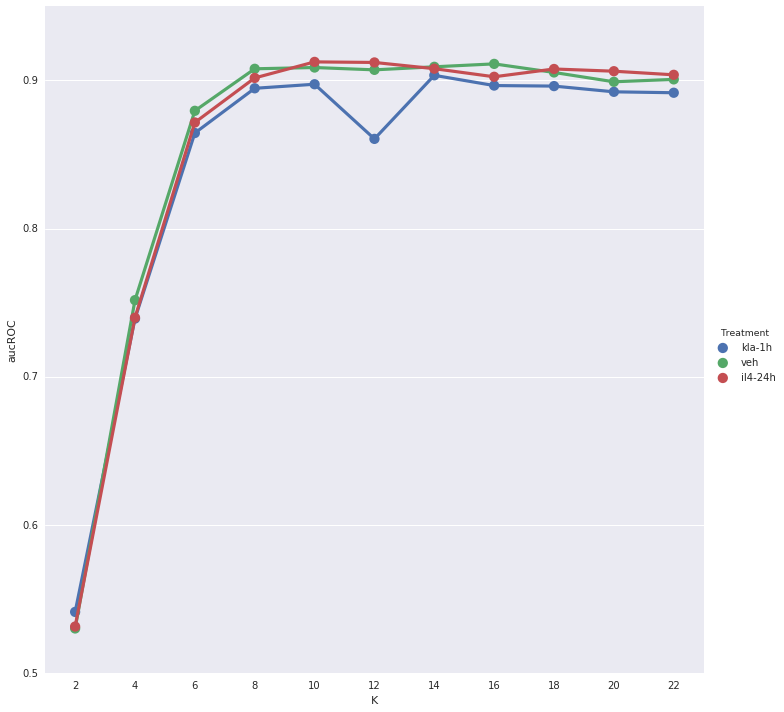

In [17]:
sns.factorplot(data = frame, x='K', y='aucROC', hue = 'Treatment', size=10)

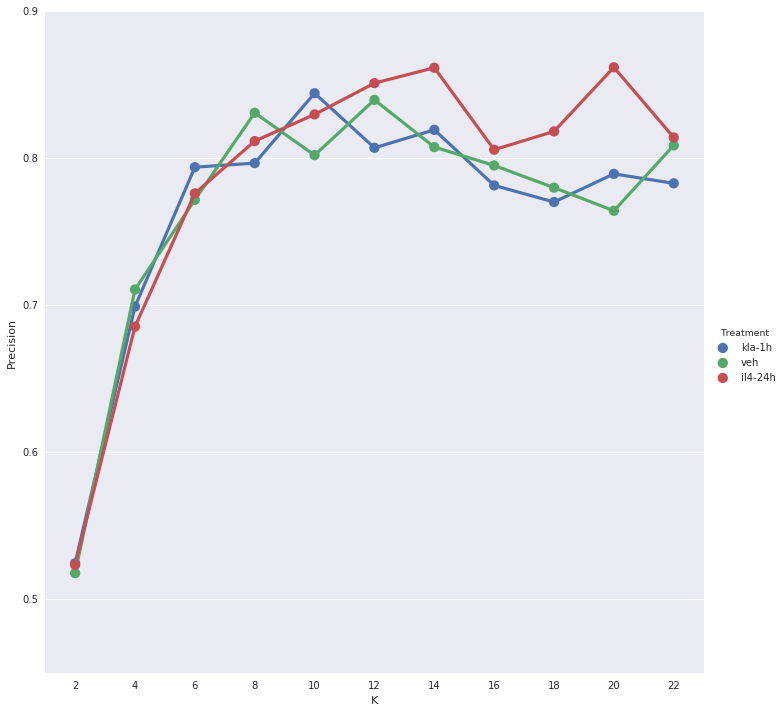

In [18]:
sns.factorplot(data = frame, x='K', y='Precision', hue = 'Treatment', size=10)

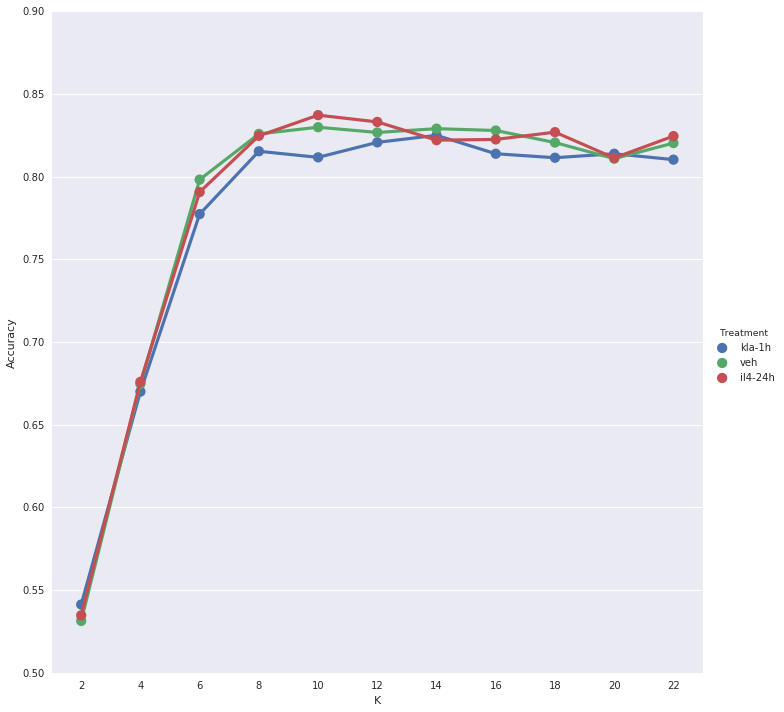

In [19]:
sns.factorplot(data = frame, x='K', y='Accuracy', hue = 'Treatment', size=10)

## Try different motif counts

In [13]:
all_rocs = []
all_accuracies = []
all_precisions = []
m_list = []
all_treatments = []
for ps in ['c57bl6_kla-1h_peaks.fasta', 'c57bl6_veh_peaks.fasta', 'c57bl6_il4-24h_peaks.fasta']:
    print(ps)
    positive_seqRecords = list(SeqIO.parse(working_directory + '/peak_sequences/' + ps, 'fasta'))
    negative_seqRecords = list(SeqIO.parse(working_directory + '/background_files/' + ps.replace('_peaks', '_background'), 'fasta'))[:len(positive_seqRecords)]

    fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords] + [str(x[:200].seq) for x in negative_seqRecords]

    fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords] + \
        [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]

    sequence_arrays = convert_sequences_to_array(fasta_seq)

    sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)


    labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
    labels = np.array(labels)

    x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)

    num_classes = 2
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    for m in range(25,250, 25):
        current_model = get_convolution_model(
            200,
            'classification',
            num_classes = 2,
            num_motifs = m,
            motif_size = 10,
            num_dense_neurons = 32, 
            dropout_rate = 0.5)
        
        current_model.fit([x_train, x_rc_train], y_train,
              batch_size=128,
              epochs=10,
              verbose=1,
              validation_data=([x_test, x_rc_test], y_test))

        probs = current_model.predict([x_test, x_rc_test])
        test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
        roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
        precision = sklearn.metrics.precision_score([y[1] for y in y_test], test_predictions)
        acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
        treatment = ps.split('_')[1]
        
        print(treatment, m, current_model.count_params())
        print(roc, precision, acc)

        all_rocs.append(roc)
        all_accuracies.append(acc)
        all_precisions.append(precision)
        m_list.append(m)
        all_treatments.append(treatment)

c57bl6_kla-1h_peaks.fasta
Train on 34841 samples, validate on 8711 samples
Epoch 1/10
34841/34841 [==============================] - 12s 334us/step - loss: 0.6902 - categorical_accuracy: 0.5357 - val_loss: 0.6733 - val_categorical_accuracy: 0.6345
Epoch 2/10
34841/34841 [==============================] - 5s 135us/step - loss: 0.6307 - categorical_accuracy: 0.6553 - val_loss: 0.5704 - val_categorical_accuracy: 0.7251
Epoch 3/10
34841/34841 [==============================] - 5s 137us/step - loss: 0.5497 - categorical_accuracy: 0.7318 - val_loss: 0.4956 - val_categorical_accuracy: 0.7686
Epoch 4/10
34841/34841 [==============================] - 5s 134us/step - loss: 0.5063 - categorical_accuracy: 0.7632 - val_loss: 0.4690 - val_categorical_accuracy: 0.7818
Epoch 5/10
34841/34841 [==============================] - 5s 132us/step - loss: 0.4844 - categorical_accuracy: 0.7785 - val_loss: 0.4525 - val_categorical_accuracy: 0.7869
Epoch 6/10
34841/34841 [==============================] - 5s 136

34841/34841 [==============================] - 8s 229us/step - loss: 0.4115 - categorical_accuracy: 0.8254 - val_loss: 0.3645 - val_categorical_accuracy: 0.8377
Epoch 6/10
34841/34841 [==============================] - 8s 233us/step - loss: 0.4007 - categorical_accuracy: 0.8321 - val_loss: 0.3724 - val_categorical_accuracy: 0.8347
Epoch 7/10
34841/34841 [==============================] - 8s 233us/step - loss: 0.3857 - categorical_accuracy: 0.8342 - val_loss: 0.3597 - val_categorical_accuracy: 0.8407
Epoch 8/10
34841/34841 [==============================] - 8s 236us/step - loss: 0.3787 - categorical_accuracy: 0.8419 - val_loss: 0.3829 - val_categorical_accuracy: 0.8291
Epoch 9/10
34841/34841 [==============================] - 8s 238us/step - loss: 0.3737 - categorical_accuracy: 0.8428 - val_loss: 0.3612 - val_categorical_accuracy: 0.8405
Epoch 10/10
34841/34841 [==============================] - 8s 228us/step - loss: 0.3666 - categorical_accuracy: 0.8466 - val_loss: 0.3541 - val_categor

Epoch 10/10
34841/34841 [==============================] - 12s 336us/step - loss: 0.3356 - categorical_accuracy: 0.8573 - val_loss: 0.3507 - val_categorical_accuracy: 0.8484
kla-1h 225 16523
0.9301146347524224 0.8053826069491866 0.8483526575594077
c57bl6_veh_peaks.fasta
Train on 50480 samples, validate on 12620 samples
Epoch 1/10
50480/50480 [==============================] - 10s 191us/step - loss: 0.6718 - categorical_accuracy: 0.5787 - val_loss: 0.5774 - val_categorical_accuracy: 0.7554
Epoch 2/10
50480/50480 [==============================] - 6s 126us/step - loss: 0.5302 - categorical_accuracy: 0.7548 - val_loss: 0.4521 - val_categorical_accuracy: 0.7917
Epoch 3/10
50480/50480 [==============================] - 6s 120us/step - loss: 0.4775 - categorical_accuracy: 0.7881 - val_loss: 0.4266 - val_categorical_accuracy: 0.8032
Epoch 4/10
50480/50480 [==============================] - 6s 114us/step - loss: 0.4566 - categorical_accuracy: 0.7996 - val_loss: 0.4187 - val_categorical_accurac

Epoch 4/10
50480/50480 [==============================] - 10s 194us/step - loss: 0.3951 - categorical_accuracy: 0.8331 - val_loss: 0.3584 - val_categorical_accuracy: 0.8416
Epoch 5/10
50480/50480 [==============================] - 10s 196us/step - loss: 0.3802 - categorical_accuracy: 0.8379 - val_loss: 0.3505 - val_categorical_accuracy: 0.8491
Epoch 6/10
50480/50480 [==============================] - 10s 198us/step - loss: 0.3756 - categorical_accuracy: 0.8432 - val_loss: 0.3524 - val_categorical_accuracy: 0.8480
Epoch 7/10
50480/50480 [==============================] - 10s 197us/step - loss: 0.3667 - categorical_accuracy: 0.8469 - val_loss: 0.3565 - val_categorical_accuracy: 0.8408
Epoch 8/10
50480/50480 [==============================] - 10s 198us/step - loss: 0.3560 - categorical_accuracy: 0.8527 - val_loss: 0.3418 - val_categorical_accuracy: 0.8539
Epoch 9/10
50480/50480 [==============================] - 10s 197us/step - loss: 0.3519 - categorical_accuracy: 0.8544 - val_loss: 0.33

50480/50480 [==============================] - 15s 288us/step - loss: 0.3342 - categorical_accuracy: 0.8640 - val_loss: 0.3544 - val_categorical_accuracy: 0.8433
Epoch 9/10
50480/50480 [==============================] - 14s 282us/step - loss: 0.3277 - categorical_accuracy: 0.8700 - val_loss: 0.3336 - val_categorical_accuracy: 0.8551
Epoch 10/10
50480/50480 [==============================] - 14s 284us/step - loss: 0.3216 - categorical_accuracy: 0.8711 - val_loss: 0.3274 - val_categorical_accuracy: 0.8586
veh 225 16523
0.9336514939665915 0.8492601726263872 0.8585578446909667
c57bl6_il4-24h_peaks.fasta
Train on 53628 samples, validate on 13408 samples
Epoch 1/10
53628/53628 [==============================] - 11s 200us/step - loss: 0.6629 - categorical_accuracy: 0.5897 - val_loss: 0.5647 - val_categorical_accuracy: 0.7147
Epoch 2/10
53628/53628 [==============================] - 7s 122us/step - loss: 0.5052 - categorical_accuracy: 0.7651 - val_loss: 0.4481 - val_categorical_accuracy: 0.794

Epoch 2/10
53628/53628 [==============================] - 11s 199us/step - loss: 0.4520 - categorical_accuracy: 0.7994 - val_loss: 0.3974 - val_categorical_accuracy: 0.8225
Epoch 3/10
53628/53628 [==============================] - 10s 196us/step - loss: 0.4070 - categorical_accuracy: 0.8268 - val_loss: 0.3828 - val_categorical_accuracy: 0.8267
Epoch 4/10
53628/53628 [==============================] - 11s 198us/step - loss: 0.3851 - categorical_accuracy: 0.8407 - val_loss: 0.3551 - val_categorical_accuracy: 0.8468
Epoch 5/10
53628/53628 [==============================] - 11s 199us/step - loss: 0.3688 - categorical_accuracy: 0.8457 - val_loss: 0.3487 - val_categorical_accuracy: 0.8496
Epoch 6/10
53628/53628 [==============================] - 11s 196us/step - loss: 0.3598 - categorical_accuracy: 0.8505 - val_loss: 0.3889 - val_categorical_accuracy: 0.8180
Epoch 7/10
53628/53628 [==============================] - 10s 195us/step - loss: 0.3514 - categorical_accuracy: 0.8544 - val_loss: 0.34

53628/53628 [==============================] - 18s 345us/step - loss: 0.3764 - categorical_accuracy: 0.8205 - val_loss: 0.3473 - val_categorical_accuracy: 0.8466
Epoch 7/10
53628/53628 [==============================] - 19s 361us/step - loss: 0.3683 - categorical_accuracy: 0.8406 - val_loss: 0.3408 - val_categorical_accuracy: 0.8505
Epoch 8/10
53628/53628 [==============================] - 18s 343us/step - loss: 0.3549 - categorical_accuracy: 0.8461 - val_loss: 0.3364 - val_categorical_accuracy: 0.8528
Epoch 9/10
53628/53628 [==============================] - 16s 305us/step - loss: 0.3483 - categorical_accuracy: 0.8493 - val_loss: 0.3728 - val_categorical_accuracy: 0.8309
Epoch 10/10
53628/53628 [==============================] - 16s 302us/step - loss: 0.3426 - categorical_accuracy: 0.8510 - val_loss: 0.3410 - val_categorical_accuracy: 0.8549
il4-24h 225 16523
0.9330638356347504 0.8596252644303415 0.8548627684964201


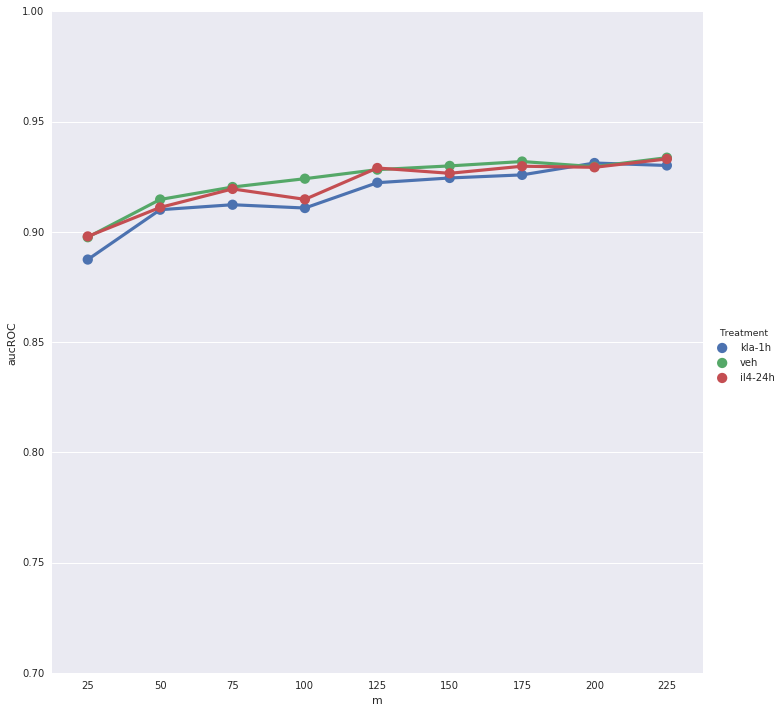

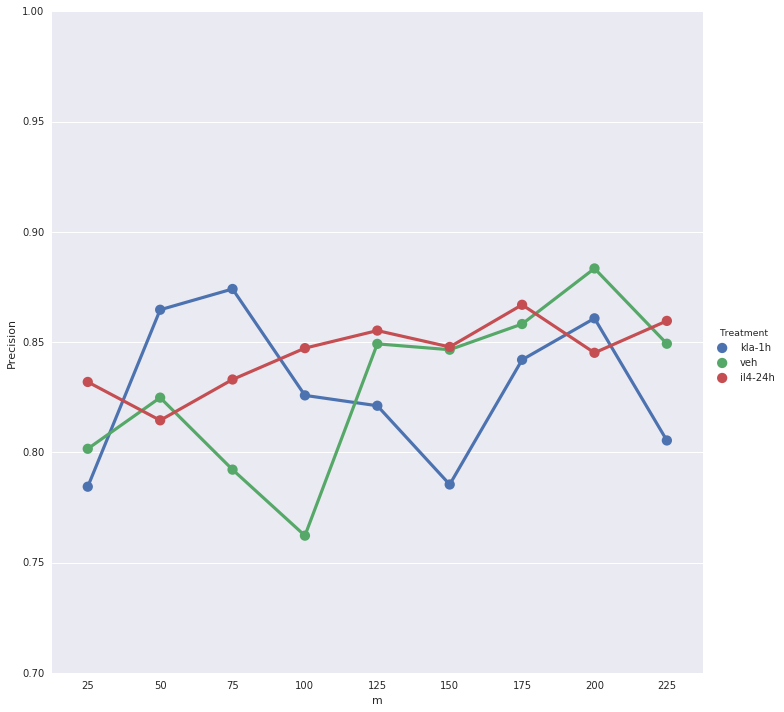

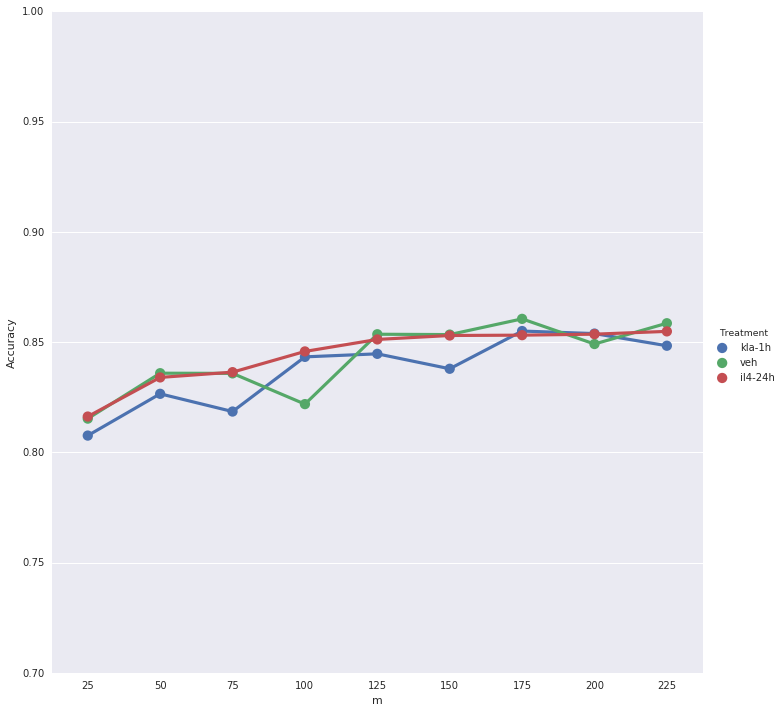

In [14]:
frame = pd.DataFrame({'aucROC':all_rocs, 
                      'Accuracy':all_accuracies, 
                      'm':m_list, 
                      'Precision':all_precisions,
                      'Treatment':all_treatments})

sns.factorplot(data = frame, x='m', y='aucROC', hue = 'Treatment', size=10)
plt.ylim(0.7,1)
plt.show()
sns.factorplot(data = frame, x='m', y='Precision', hue = 'Treatment', size=10)
plt.ylim(0.7,1)
plt.show()

sns.factorplot(data = frame, x='m', y='Accuracy', hue = 'Treatment', size=10)
plt.ylim(0.7,1)
plt.show()


## Dense Only Analysis

In [ ]:
def get_dense_model(
    total_seq_length=200,
    seq_size = 150,
    num_classes = 2,
    neurons_per_layer=32
    motif_size = 20,
    num_dense_neurons = 25, 
    dropout_rate = 0.25
    ):
    input_fwd = Input(shape=(total_seq_length,4), name='input_fwd')
    input_rev = Input(shape=(total_seq_length,4), name='input_rev')

    # find motifs
    convolution_layer = Conv1D(filters=num_motifs, 
        kernel_size=motif_size,
        activation='relu',
        input_shape=(total_seq_length,4),
        name='convolution_layer',
        padding = 'same'
        )
    forward_motif_scores = convolution_layer(input_fwd)
    reverse_motif_scores = convolution_layer(input_rev)

    # crop motif scores to avoid parts of sequence where motif score is computed in only one direction
    to_crop = int((total_seq_length - seq_size)/2)
    crop_layer = Cropping1D(cropping=(to_crop, to_crop), 
        name='crop_layer')
    cropped_fwd_scores = crop_layer(forward_motif_scores)
    cropped_rev_scores = crop_layer(reverse_motif_scores)

    # calculate max scores for each orientation
    seq_pool_layer = MaxPool1D(pool_size=seq_size)
    max_fwd_scores = seq_pool_layer(cropped_fwd_scores)
    max_rev_scores = seq_pool_layer(cropped_rev_scores)

    # calculate max score for strand
    orientation_max_layer = Maximum()
    max_seq_scores = orientation_max_layer([max_fwd_scores, max_rev_scores])

    # fully connected layer
    dense_out = Dense(num_dense_neurons, activation='relu', 
                     )(max_seq_scores)

    # drop out
    drop_out = Dropout(0.25)(dense_out)

    # make prediction
    flattened = Flatten()(drop_out)
    predictions = Dense(num_classes,
                        activation = 'softmax', 
                       )(flattened)
    
    # define and compile model
    convolution_model = Model(inputs=[input_fwd, input_rev], outputs=predictions)

    return convolution_model

In [ ]:
for ps in ['c57bl6_kla-1h_peaks.fasta', 'c57bl6_veh_peaks.fasta', 'c57bl6_il4-24h_peaks.fasta']:
    print(ps)
    positive_seqRecords = list(SeqIO.parse('./peak_sequences/' + ps, 'fasta'))
    negative_seqRecords = list(SeqIO.parse('./background_files/' + ps.replace('_peaks', '_background'), 'fasta'))[:len(positive_seqRecords)]

    fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords] + [str(x[:200].seq) for x in negative_seqRecords]

    fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords] + \
        [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]

    sequence_arrays = convert_sequences_to_array(fasta_seq)

    sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)


    labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
    labels = np.array(labels)

    x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)

    num_classes = 2
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    
    input_fwd = Input(shape=(total_seq_length,4), name='input_fwd')
    dense_out_1 = Dense(32, activation='relu', 
                 )(input_fwd)
    dense_out_2 = Dense(32, activation='relu', 
                 )(dense_out_1)
    dense_out_3 = Dense(32, activation='relu', 
                 )(dense_out_2)
    # drop out
    drop_out = Dropout(0.5)(dense_out_3)

    # make prediction
    flattened = Flatten()(drop_out)
    predictions = Dense(num_classes,
                        activation = 'softmax', 
                       )(flattened)
    
    current_model = Model(inputs=[input_fwd], outputs=predictions)


    current_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    current_model.fit([x_train], y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=([x_test], y_test))

    probs = current_model.predict([x_test])

    roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
    precision = sklearn.metrics.precision_score([y[1] for y in y_test], [1 if x > 0.5 else 0 for x in probs[:,1]])
    acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], [1 if x > 0.5 else 0 for x in probs[:,1]])
    treatment = ps.split('_')[1]

    print(treatment )
    print(roc, precision, acc)
